# Problem Statement

Suppose that you are the administrator of a university department and you want to determine each applicant’s chance of admission based on their results on two exams.
* You have historical data from previous applicants that you can use as a training set for logistic regression.
* For each training example, you have the applicant’s scores on two exams and the admissions decision.
* Your task is to build a classification model that estimates an applicant’s probability of admission based on the scores from those two exams.



In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy
import math

%matplotlib inline

- The `load_dataset()` function shown below loads the data into variables `X_train` and `y_train`
  - `X_train` contains exam scores on two exams for a student
  - `y_train` is the admission decision
      - `y_train = 1` if the student was admitted
      - `y_train = 0` if the student was not admitted

In [6]:
#load data
data = pd.read_csv("/content/ex2data1.txt", header=None)

# Memisahkan fitur dan label
X_train = data.iloc[:, :-1].values
y_train = data.iloc[:, -1].values

print ('The shape of X_train is: ' + str(X_train.shape))
print ('The shape of y_train is: ' + str(y_train.shape))

The shape of X_train is: (100, 2)
The shape of y_train is: (100,)


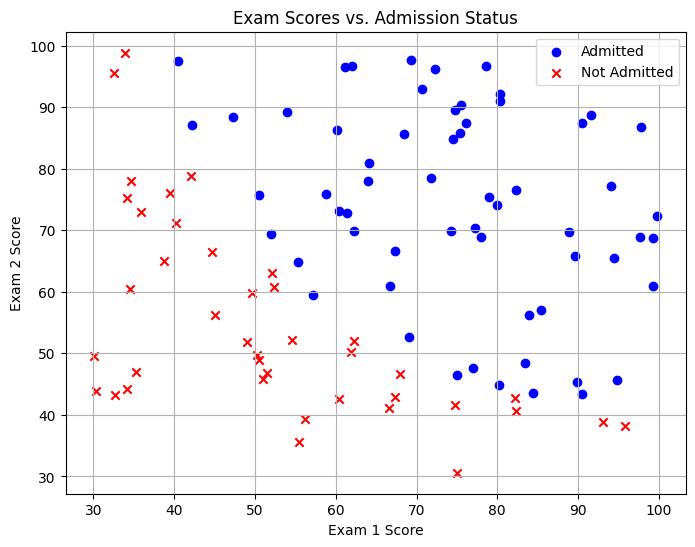

In [7]:
# Separate data based on label
admitted = X_train[y_train == 1]
not_admitted = X_train[y_train == 0]

# Plot the data
plt.figure(figsize=(8,6))
plt.scatter(admitted[:, 0], admitted[:, 1], c='b', marker='o', label='Admitted')
plt.scatter(not_admitted[:, 0], not_admitted[:, 1], c='r', marker='x', label='Not Admitted')

# Set axis labels
plt.xlabel('Exam 1 Score')
plt.ylabel('Exam 2 Score')

# Show legend and plot
plt.legend(loc='upper right')
plt.title('Exam Scores vs. Admission Status')
plt.grid(True)
plt.show()


## Sigmoid Function
Recall that for logistic regression, the model is represented as

$$ f_{\mathbf{w},b}(x) = g(\mathbf{w}\cdot \mathbf{x} + b)$$
where function $g$ is the sigmoid function. The sigmoid function is defined as:

$$g(z) = \frac{1}{1+e^{-z}}$$

the `sigmoid` function to calculate

$$g(z) = \frac{1}{1+e^{-z}}$$

Note that
- `z` is not always a single number, but can also be an array of numbers.
- If the input is an array of numbers, we'd like to apply the sigmoid function to each value in the input array.

In [8]:
def sigmoid(z):

    g = 1/(1+ np.exp(-z))
    return g

## Cost function
Recall that for logistic regression, the cost function is of the form

$$ J(\mathbf{w},b) = \frac{1}{m}\sum_{i=0}^{m-1} \left[ loss(f_{\mathbf{w},b}(\mathbf{x}^{(i)}), y^{(i)}) \right] \tag{1}$$

where
* m is the number of training examples in the dataset


* $loss(f_{\mathbf{w},b}(\mathbf{x}^{(i)}), y^{(i)})$ is the cost for a single data point, which is -

    $$loss(f_{\mathbf{w},b}(\mathbf{x}^{(i)}), y^{(i)}) = (-y^{(i)} \log\left(f_{\mathbf{w},b}\left( \mathbf{x}^{(i)} \right) \right) - \left( 1 - y^{(i)}\right) \log \left( 1 - f_{\mathbf{w},b}\left( \mathbf{x}^{(i)} \right) \right) \tag{2}$$
    
    
*  $f_{\mathbf{w},b}(\mathbf{x}^{(i)})$ is the model's prediction, while $y^{(i)}$, which is the actual label

*  $f_{\mathbf{w},b}(\mathbf{x}^{(i)}) = g(\mathbf{w} \cdot \mathbf{x^{(i)}} + b)$ where function $g$ is the sigmoid function.
    * It might be helpful to first calculate an intermediate variable $z_{\mathbf{w},b}(\mathbf{x}^{(i)}) = \mathbf{w} \cdot \mathbf{x^{(i)}} + b = w_0x^{(i)}_0 + ... + w_{n-1}x^{(i)}_{n-1} + b$ where $n$ is the number of features, before calculating $f_{\mathbf{w},b}(\mathbf{x}^{(i)}) = g(z_{\mathbf{w},b}(\mathbf{x}^{(i)}))$

Note:
* As you are doing this, remember that the variables `X_train` and `y_train` are not scalar values but matrices of shape ($m, n$) and ($𝑚$,1) respectively, where  $𝑛$ is the number of features and $𝑚$ is the number of training examples.
* You can use the sigmoid function that you implemented above for this part.

In [16]:
def compute_cost(X, y, w, b, *argv):
    m, n = X.shape
    cost = 0.
    for i in range(m):
        z_i = np.dot(X[i], w) + b                                      #(n,)(n,)=scalar, see np.dot
        f_wb_i = sigmoid(z_i)                                          #scalar
        cost +=  -y[i]*np.log(f_wb_i) - (1-y[i])*np.log(1-f_wb_i)      #scalar

    total_cost = cost/m

    return total_cost

In [17]:
m, n = X_train.shape

# Compute and display cost with w and b initialized to zeros
initial_w = np.zeros(n)
initial_b = 0.
cost = compute_cost(X_train, y_train, initial_w, initial_b)
print('Cost at initial w and b (zeros): {:.3f}'.format(cost))

Cost at initial w and b (zeros): 0.693


## Gradient

Recall that the gradient descent algorithm is:

$$\begin{align*}& \text{repeat until convergence:} \; \lbrace \newline \; & b := b -  \alpha \frac{\partial J(\mathbf{w},b)}{\partial b} \newline       \; & w_j := w_j -  \alpha \frac{\partial J(\mathbf{w},b)}{\partial w_j} \tag{1}  \; & \text{for j := 0..n-1}\newline & \rbrace\end{align*}$$

where, parameters $b$, $w_j$ are all updated simultaniously

`compute_gradient` function to compute $\frac{\partial J(\mathbf{w},b)}{\partial w}$, $\frac{\partial J(\mathbf{w},b)}{\partial b}$ from equations (2) and (3) below.

$$
\frac{\partial J(\mathbf{w},b)}{\partial b}  = \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - \mathbf{y}^{(i)}) \tag{2}
$$
$$
\frac{\partial J(\mathbf{w},b)}{\partial w_j}  = \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - \mathbf{y}^{(i)})x_{j}^{(i)} \tag{3}
$$
* m is the number of training examples in the dataset

    
*  $f_{\mathbf{w},b}(x^{(i)})$ is the model's prediction, while $y^{(i)}$ is the actual label


- **Note**: While this gradient looks identical to the linear regression gradient, the formula is actually different because linear and logistic regression have different definitions of $f_{\mathbf{w},b}(x)$.

In [22]:

def compute_gradient(X, y, w, b, *argv):
    m,n = X.shape
    dj_dw = np.zeros((n,))                            #(n,)
    dj_db = 0.0                                       #scalar

    for i in range(m):
        f_wb_i = sigmoid(np.dot(X[i],w) + b)          #(n,)(n,)=scalar
        err_i  = f_wb_i  - y[i]                       #scalar
        for j in range(n):
            dj_dw[j] = dj_dw[j] + err_i * X[i,j]      #scalar
        dj_db = dj_db + err_i
    dj_dw = dj_dw/m                                   #(n,)
    dj_db = dj_db/m                                   #scalar


    return dj_db, dj_dw

In [23]:
# Compute and display gradient with w and b initialized to zeros
initial_w = np.zeros(n)
initial_b = 0.

dj_db, dj_dw = compute_gradient(X_train, y_train, initial_w, initial_b)
print(f'dj_db at initial w and b (zeros):{dj_db}' )
print(f'dj_dw at initial w and b (zeros):{dj_dw.tolist()}' )

dj_db at initial w and b (zeros):-0.1
dj_dw at initial w and b (zeros):[-12.00921658929115, -11.262842205513591]


##Learning parameters using gradient descent
 find the optimal parameters of a logistic regression model by using gradient descent.
- You don't need to implement anything for this part. Simply run the cells below.

- A good way to verify that gradient descent is working correctly is to look
at the value of $J(\mathbf{w},b)$ and check that it is decreasing with each step.

- Assuming you have implemented the gradient and computed the cost correctly, your value of $J(\mathbf{w},b)$ should never increase, and should converge to a steady value by the end of the algorithm.

In [24]:
def gradient_descent(X, y, w_in, b_in, cost_function, gradient_function, alpha, num_iters, lambda_):
    # number of training examples
    m = len(X)

    # An array to store cost J and w's at each iteration primarily for graphing later
    J_history = []
    w_history = []

    for i in range(num_iters):

        # Calculate the gradient and update the parameters
        dj_db, dj_dw = gradient_function(X, y, w_in, b_in, lambda_)

        # Update Parameters using w, b, alpha and gradient
        w_in = w_in - alpha * dj_dw
        b_in = b_in - alpha * dj_db

        # Save cost J at each iteration
        if i<100000:      # prevent resource exhaustion
            cost =  cost_function(X, y, w_in, b_in, lambda_)
            J_history.append(cost)

        # Print cost every at intervals 10 times or as many iterations if < 10
        if i% math.ceil(num_iters/10) == 0 or i == (num_iters-1):
            w_history.append(w_in)
            print(f"Iteration {i:4}: Cost {float(J_history[-1]):8.2f}   ")

    return w_in, b_in, J_history, w_history #return w and J,w history for graphing

In [25]:
np.random.seed(1)
initial_w = 0.01 * (np.random.rand(2) - 0.5)
initial_b = -8

# Some gradient descent settings
iterations = 10000
alpha = 0.001

w,b, J_history,_ = gradient_descent(X_train ,y_train, initial_w, initial_b,
                                   compute_cost, compute_gradient, alpha, iterations, 0)

Iteration    0: Cost     0.96   
Iteration 1000: Cost     0.31   
Iteration 2000: Cost     0.30   
Iteration 3000: Cost     0.30   
Iteration 4000: Cost     0.30   
Iteration 5000: Cost     0.30   
Iteration 6000: Cost     0.30   
Iteration 7000: Cost     0.30   
Iteration 8000: Cost     0.30   
Iteration 9000: Cost     0.30   
Iteration 9999: Cost     0.30   


##  Plotting the decision boundary

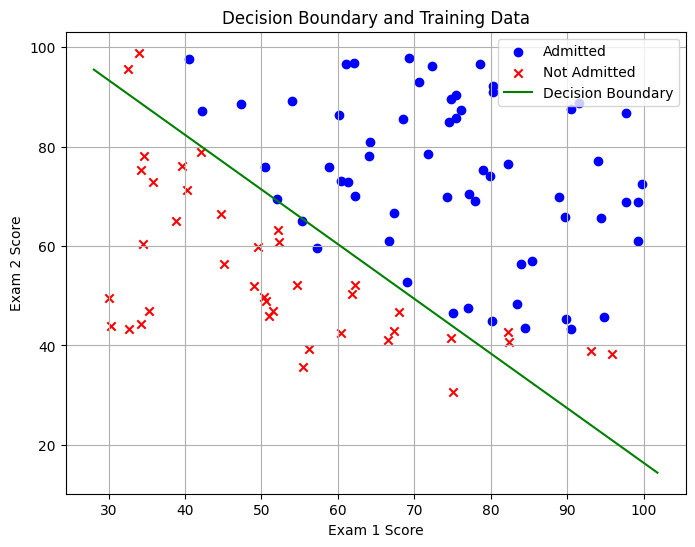

In [26]:
# Create the plot
plt.figure(figsize=(8,6))

# Plot admitted students with blue circles
plt.scatter(admitted[:, 0], admitted[:, 1], c='b', marker='o', label='Admitted')

# Plot not admitted students with red x's
plt.scatter(not_admitted[:, 0], not_admitted[:, 1], c='r', marker='x', label='Not Admitted')

# Plot decision boundary
# For a linear model: w1*x1 + w2*x2 + b = 0
# Solve for x2: x2 = -(w1*x1 + b)/w2
x_values = np.array([np.min(X_train[:, 0]) - 2, np.max(X_train[:, 0]) + 2])  # Two x points to define the line
y_values = -(w[0] * x_values + b) / w[1]                                     # Corresponding y points

# Draw the decision boundary line
plt.plot(x_values, y_values, label='Decision Boundary', color='green')

# Set the axis labels
plt.xlabel('Exam 1 Score')
plt.ylabel('Exam 2 Score')

# Add legend to the upper right corner
plt.legend(loc='upper right')

# Add a title and grid
plt.title('Decision Boundary and Training Data')
plt.grid(True)

# Display the plot
plt.show()


## Evaluating logistic regression

the `predict` function to produce `1` or `0` predictions given a dataset and a learned parameter vector $w$ and $b$.
- First you need to compute the prediction from the model $f(x^{(i)}) = g(w \cdot x^{(i)} + b)$ for every example
    - You've implemented this before in the parts above
- We interpret the output of the model ($f(x^{(i)})$) as the probability that $y^{(i)}=1$ given $x^{(i)}$ and parameterized by $w$.
- Therefore, to get a final prediction ($y^{(i)}=0$ or $y^{(i)}=1$) from the logistic regression model, you can use the following heuristic -

  if $f(x^{(i)}) >= 0.5$, predict $y^{(i)}=1$
  
  if $f(x^{(i)}) < 0.5$, predict $y^{(i)}=0$

In [27]:
def predict(X, w, b):

    # number of training examples
    m, n = X.shape
    p = np.zeros(m)

    # Loop over each example
    for i in range(m):
        z_wb = 0
        # Loop over each feature
        for j in range(n):
            # Add the corresponding term to z_wb
            z_wb_ij = X[i, j] * w[j]
            z_wb += z_wb_ij

        # Add bias term
        z_wb += b

        # Calculate the prediction for this example
        f_wb = sigmoid(z_wb)

        # Apply the threshold
        p[i] = f_wb >= 0.5

    return p

In [29]:
#Compute accuracy on training set
p = predict(X_train, w,b)
print('Train Accuracy: %f'%(np.mean(p == y_train) * 100))

Train Accuracy: 92.000000
